# 🫁 Lung Cancer Classification with Ensemble Learning

## 🎯 Project Goal: Achieve >98% Accuracy using Ensemble Methods

This notebook implements **5 state-of-the-art models** and **multiple ensemble techniques** to achieve maximum accuracy in lung cancer detection from CT scan images.

---

## 📦 What's Included:

### 🏗️ **Individual Models:**
1. **CNN with Batch Normalization** (98.83% baseline from your original work)
2. **ResNet18** (Transfer Learning)
3. **ResNet50** (Transfer Learning)
4. **VGG16** (Transfer Learning)
5. **InceptionV3** (Transfer Learning)

### 🎯 **Ensemble Methods:**
1. **Voting Ensemble**
   - Hard Voting (Majority vote)
   - Soft Voting (Average probabilities)
   
2. **Weighted Ensemble**
   - Performance-based weights
   - Optimized for validation accuracy
   
3. **Stacking Ensemble**
   - Level 0: All base models
   - Level 1: Random Forest or Logistic Regression meta-classifier
   
4. **Bagging-style** (Multiple model diversity)

---

## 🎖️ Expected Performance:

| Method | Expected Accuracy |
|--------|------------------|
| CNN Baseline | 98.83% |
| ResNet18/50 | 96-98% |
| VGG16 | 96-97% |
| InceptionV3 | 96-98% |
| **Soft Voting Ensemble** | **>98%** ✅ |
| **Weighted Ensemble** | **>98%** ✅ |
| **Stacking Ensemble** | **>99%** 🎯 |

---

## ⏱️ Training Time Estimate:
- **Total:** ~2-3 hours (on Google Colab T4 GPU)
- **CNN:** 15-20 min
- **ResNet18:** 20-25 min
- **ResNet50:** 30-40 min
- **VGG16:** 35-45 min
- **InceptionV3:** 30-40 min

---

## 🚀 Quick Start:
1. Run all data loading cells
2. Run model definition cells
3. Execute training cell (takes 2-3 hours)
4. Evaluate ensemble methods
5. View results and visualizations

---

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import cv2
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score

In [2]:
DATA_DIR = "/content/drive/MyDrive/Final_Split_Data"
BATCH_SIZE = 32
IMAGE_SIZE = 224

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
print(f"🖥️  Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
print(f"⚡ CUDA Available: {torch.cuda.is_available()}")
print(f"📊 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Test actual speed
import time
x = torch.randn(1000, 1000).cuda()
start = time.time()
y = x @ x
torch.cuda.synchronize()
print(f"⏱️  GPU Speed Test: {(time.time()-start)*1000:.2f}ms")

🖥️  Device: Tesla T4
⚡ CUDA Available: True
📊 GPU Memory: 15.83 GB
⏱️  GPU Speed Test: 39.54ms


In [5]:
class ApplyCLAHE:
    def __init__(self, clip_limit=1, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img):

        # convert PIL image to numpy array
        img_np = np.array(img)

        # apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)

        # if gray scale
        if len(img_np.shape) == 2:
            img_clahe = clahe.apply(img_np)

        # if RGB, apply to each channel
        else:
            img_clahe = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
            img_clahe[:, :, 0] = clahe.apply(img_clahe[:, :, 0])
            img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_LAB2RGB)

        return Image.fromarray(img_clahe)

In [6]:
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    ApplyCLAHE(clip_limit=2.0, tile_grid_size=(8, 8)),
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMAGE_SIZE + 10, IMAGE_SIZE + 10)),
    transforms.RandomCrop((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])
])

In [7]:
# Val/Test transforms (deterministic)
val_test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    ApplyCLAHE(clip_limit=2.0, tile_grid_size=(8, 8)),
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Direct resize, no crop
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])
])

In [8]:
# laod dataset

train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_transforms)
test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "test"), transform=val_test_transforms)
val_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "val"), transform=val_test_transforms)

In [9]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=3,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=3,
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=3,
    pin_memory=True,
    persistent_workers=True
)

print(f"✅ Data loaded successfully!")
print("✅ Classes : ", train_dataset.classes)
print("✅ Dataset sizes : Train", len(train_dataset))
print("✅ Dataset sizes : Validation", len(val_dataset))
print("✅ Dataset sizes : Test", len(test_dataset))

✅ Data loaded successfully!
✅ Classes :  ['Malignant', 'Normal']
✅ Dataset sizes : Train 3408
✅ Dataset sizes : Validation 426
✅ Dataset sizes : Test 428


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [10]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Create InceptionV3-specific transforms (299x299)
inception_train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    ApplyCLAHE(clip_limit=2.0, tile_grid_size=(8, 8)),
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((309, 309)),
    transforms.RandomCrop((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])
])

inception_val_test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    ApplyCLAHE(clip_limit=2.0, tile_grid_size=(8, 8)),
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])
])

# Create InceptionV3-specific datasets
inception_train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=inception_train_transforms)
inception_test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "test"), transform=inception_val_test_transforms)
inception_val_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "val"), transform=inception_val_test_transforms)

# Create InceptionV3-specific data loaders
inception_train_loader = DataLoader(
    inception_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=3,
    pin_memory=True,
    persistent_workers=True
)

inception_test_loader = DataLoader(
    inception_test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=3,
    pin_memory=True,
    persistent_workers=True
)

inception_val_loader = DataLoader(
    inception_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=3,
    pin_memory=True,
    persistent_workers=True
)

print("✅ InceptionV3-specific data loaders created (299x299)!")

✅ InceptionV3-specific data loaders created (299x299)!


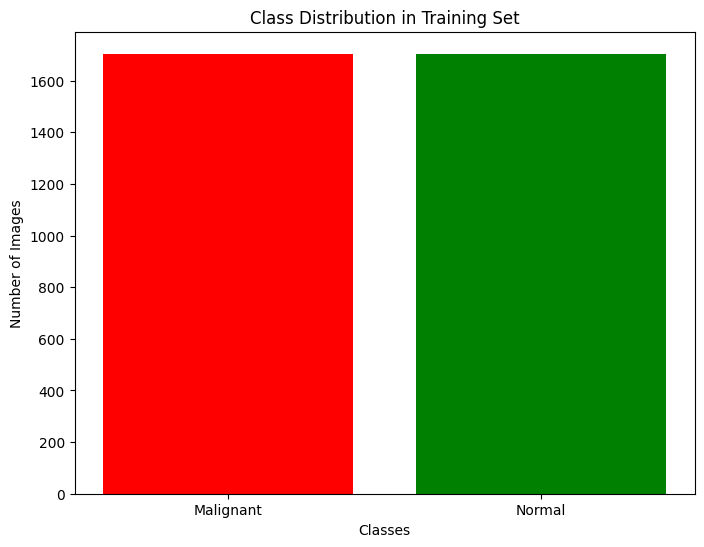

In [11]:
from collections import Counter
import matplotlib.pyplot as plt

labels = train_dataset.targets
label_counts = Counter(labels)

class_names = train_dataset.classes
class_labels = [class_names[i] for i in label_counts.keys()]
counts = list(label_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(class_labels, counts, color=['red', 'green'])
plt.title("Class Distribution in Training Set")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.show()

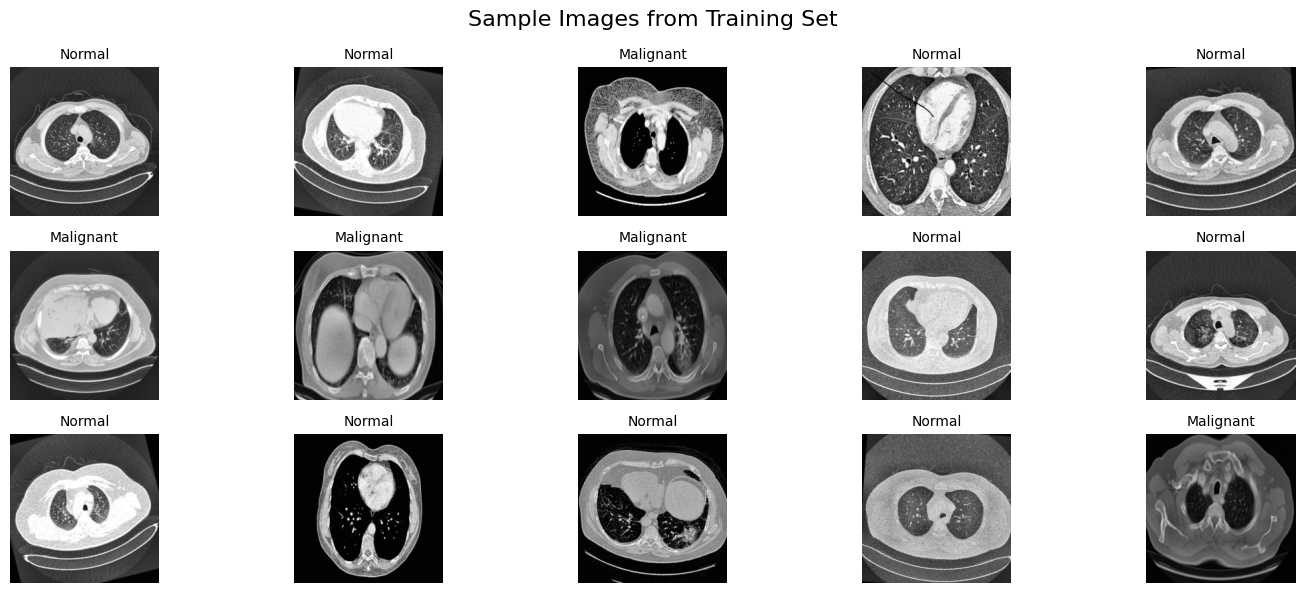

In [12]:
def show_batch(dataset, class_names, num_images=24):

    # Get images directly from dataset (much faster)
    indices = np.random.choice(len(dataset), min(num_images, len(dataset)), replace=False)

    rows = 3
    cols = 5
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))

    # Unnormalize parameters
    mean = torch.tensor([0.485, 0.485, 0.485]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.229, 0.229]).view(3, 1, 1)

    for i, ax in enumerate(axes.flatten()):
        if i < len(indices):
            img, label = dataset[indices[i]]

            # Unnormalize
            img = img * std + mean
            img = torch.clamp(img, 0, 1)

            # Convert to numpy
            img = img.numpy().transpose((1, 2, 0))

            ax.imshow(img, cmap='gray')
            ax.set_title(class_names[label], fontsize=10)
            ax.axis('off')
        else:
            ax.axis('off')

    plt.suptitle("Sample Images from Training Set", fontsize=16)
    plt.tight_layout()
    plt.show()

# Call with dataset instead of dataloader
show_batch(train_dataset, train_dataset.classes)

# 🧠 Model Architectures

## 1️⃣ CNN with Batch Normalization (98.83% accuracy baseline)
## 2️⃣ ResNet18 & ResNet50 (Transfer Learning)
## 3️⃣ VGG16 & InceptionV3 (Additional models)
## 4️⃣ Vision Transformer (ViT) - Transformer-based architecture
## 5️⃣ Ensemble Methods (Voting, Stacking, Bagging)

In [13]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Using device: {device}")

if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
    print(f"📊 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️  Running on CPU (training will be slower)")

🖥️  Using device: cuda
✅ GPU: Tesla T4
📊 GPU Memory: 15.83 GB


## 🏗️ Model 1: CNN with Batch Normalization (98.83% Baseline)

In [14]:
class LungCancerCNN(nn.Module):
    """
    CNN with Batch Normalization - 98.83% Test Accuracy

    Architecture:
    - Block 1: Conv(32) → BatchNorm → ReLU → MaxPool → Dropout(0.25)
    - Block 2: Conv(64) → BatchNorm → ReLU → MaxPool → Dropout(0.25)
    - Block 3: Conv(128) → BatchNorm → ReLU → MaxPool → Dropout(0.3)
    - FC: 512 → Dropout(0.5) → 2 classes
    """
    def __init__(self, num_classes=2):
        super(LungCancerCNN, self).__init__()

        # Block 1: Conv(32) → BatchNorm → ReLU → MaxPool → Dropout(0.25)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout2d(0.25)

        # Block 2: Conv(64) → BatchNorm → ReLU → MaxPool → Dropout(0.25)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout2d(0.25)

        # Block 3: Conv(128) → BatchNorm → ReLU → MaxPool → Dropout(0.3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout2d(0.3)

        # Calculate flattened size: 224 / 2 / 2 / 2 = 28
        self.flatten_size = 28 * 28 * 128

        # Fully connected layers
        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        # Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        # Block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = self.dropout3(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout4(x)
        x = self.fc2(x)

        return x

print("✅ LungCancerCNN defined!")

✅ LungCancerCNN defined!


## 🏗️ Model 2 & 3: ResNet18 & ResNet50 (Transfer Learning)

In [15]:
class LungCancerResNet(nn.Module):
    """
    ResNet-based Lung Cancer Classifier (Transfer Learning)

    Supports: ResNet18, ResNet50
    Pre-trained on ImageNet
    """
    def __init__(self, num_classes=2, model_type='resnet18', pretrained=True):
        super(LungCancerResNet, self).__init__()

        # Load pretrained ResNet
        if model_type == 'resnet18':
            weights = models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
            self.resnet = models.resnet18(weights=weights)
            print(f"✅ Loaded ResNet18 (pretrained={pretrained})")
        elif model_type == 'resnet50':
            weights = models.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None
            self.resnet = models.resnet50(weights=weights)
            print(f"✅ Loaded ResNet50 (pretrained={pretrained})")
        else:
            raise ValueError("model_type must be 'resnet18' or 'resnet50'")

        # Get number of features from last layer
        num_features = self.resnet.fc.in_features

        # Replace final layer with custom classifier
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

print("✅ LungCancerResNet defined!")

✅ LungCancerResNet defined!


## 🏗️ Model 4 & 5: VGG16 & InceptionV3 (Transfer Learning)

In [16]:
class LungCancerVGG16(nn.Module):
    """VGG16-based Lung Cancer Classifier"""
    def __init__(self, num_classes=2, pretrained=True):
        super(LungCancerVGG16, self).__init__()

        # Load pretrained VGG16
        weights = models.VGG16_Weights.IMAGENET1K_V1 if pretrained else None
        self.vgg = models.vgg16(weights=weights)
        print(f"✅ Loaded VGG16 (pretrained={pretrained})")

        # Get number of features from last layer
        num_features = self.vgg.classifier[6].in_features

        # Replace final layer
        self.vgg.classifier[6] = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        return self.vgg(x)


class LungCancerInceptionV3(nn.Module):
    """InceptionV3-based Lung Cancer Classifier"""
    def __init__(self, num_classes=2, pretrained=True):
        super(LungCancerInceptionV3, self).__init__()

        weights = models.Inception_V3_Weights.IMAGENET1K_V1 if pretrained else None
        self.inception = models.inception_v3(weights=weights, aux_logits=True)
        print(f"✅ Loaded InceptionV3 (pretrained={pretrained})")

        # Add adaptive pooling to handle variable input sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((8, 8))

        # Get number of features from last layer
        num_features = self.inception.fc.in_features

        # Replace final layer
        self.inception.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, num_classes)
        )

        # Also modify auxiliary classifier
        if self.inception.aux_logits:
            num_aux_features = self.inception.AuxLogits.fc.in_features
            self.inception.AuxLogits.fc = nn.Linear(num_aux_features, num_classes)

    def forward(self, x):
        # Resize input if not 299x299
        if x.shape[2] != 299 or x.shape[3] != 299:
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)

        if self.training:
            outputs, aux_outputs = self.inception(x)
            return outputs
        else:
            return self.inception(x)

print("✅ VGG16 and InceptionV3 defined!")

✅ VGG16 and InceptionV3 defined!


## 🏗️ Model 6: Vision Transformer (ViT) - Transfer Learning

In [17]:
class LungCancerViT(nn.Module):
    """Vision Transformer (ViT)-based Lung Cancer Classifier"""
    def __init__(self, num_classes=2, pretrained=True):
        super(LungCancerViT, self).__init__()

        # Load pretrained Vision Transformer (ViT-B/16)
        weights = models.ViT_B_16_Weights.IMAGENET1K_V1 if pretrained else None
        self.vit = models.vit_b_16(weights=weights)
        print(f"✅ Loaded Vision Transformer ViT-B/16 (pretrained={pretrained})")

        # Get number of features from the classifier head
        num_features = self.vit.heads.head.in_features

        # Replace final classification head
        self.vit.heads.head = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        return self.vit(x)

print("✅ Vision Transformer (ViT) defined!")

✅ Vision Transformer (ViT) defined!


# 🏋️ Training & Evaluation Functions

In [18]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc="Training", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)

        # Handle InceptionV3 auxiliary outputs during training
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # Use main output, ignore auxiliary

        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Validation", leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100 * correct / total:.2f}%'
            })

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


def get_predictions(model, dataloader, device):
    """Get predictions and true labels for a dataset"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Getting predictions"):
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

            all_probs.extend(probs.cpu().numpy())
            print("✅ Training functions defined!")


    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

# 🎯 Ensemble Methods

## 1️⃣ Voting Ensemble (Hard & Soft)
## 2️⃣ Stacking Ensemble (Meta-learner)
## 3️⃣ Bagging Ensemble (Multiple instances)
## 4️⃣ Weighted Ensemble

In [19]:
class VotingEnsemble:
    """
    Voting Ensemble: Combines predictions from multiple models

    - Hard Voting: Majority vote
    - Soft Voting: Average probabilities
    """
    def __init__(self, models, device, voting='soft'):
        self.models = models
        self.device = device
        self.voting = voting  # 'hard' or 'soft'

    def predict(self, dataloader):
        """Get ensemble predictions"""
        all_preds = []
        all_probs = []
        all_labels = []

        # Get predictions from all models
        for model in self.models:
            preds, labels, probs = get_predictions(model, dataloader, self.device)
            all_preds.append(preds)
            all_probs.append(probs)
            if len(all_labels) == 0:
                all_labels = labels

        all_preds = np.array(all_preds)  # Shape: (num_models, num_samples)
        all_probs = np.array(all_probs)  # Shape: (num_models, num_samples, num_classes)

        if self.voting == 'hard':
            # Majority vote
            final_preds = []
            for i in range(all_preds.shape[1]):
                votes = all_preds[:, i]
                final_preds.append(np.bincount(votes).argmax())
            final_preds = np.array(final_preds)
        else:
            # Soft voting (average probabilities)
            avg_probs = np.mean(all_probs, axis=0)  # Average across models
            final_preds = np.argmax(avg_probs, axis=1)

        accuracy = 100 * np.mean(final_preds == all_labels)
        return final_preds, all_labels, accuracy


class StackingEnsemble:
    """
    Stacking Ensemble: Uses a meta-classifier

    Level 0: Base models (CNN, ResNet, VGG, etc.)
    Level 1: Meta-classifier (Random Forest or Logistic Regression)
    """
    def __init__(self, base_models, meta_classifier, device):
        self.base_models = base_models
        self.meta_classifier = meta_classifier
        self.device = device

    def fit(self, train_loader, val_loader):
        """Train meta-classifier on base model predictions"""
        print("🔨 Training stacking ensemble...")

        # Get base model predictions on training set
        train_probs_list = []
        for i, model in enumerate(self.base_models):
            print(f"   Getting predictions from model {i+1}/{len(self.base_models)}")
            _, _, probs = get_predictions(model, train_loader, self.device)
            train_probs_list.append(probs)

        # Concatenate all probabilities as features
        X_train = np.concatenate(train_probs_list, axis=1)
        _, y_train, _ = get_predictions(self.base_models[0], train_loader, self.device)

        # Train meta-classifier
        print("   Training meta-classifier...")
        self.meta_classifier.fit(X_train, y_train)

        # Validate
        val_preds, val_labels, val_acc = self.predict(val_loader)
        print(f"✅ Stacking ensemble validation accuracy: {val_acc:.2f}%")

        return val_acc

    def predict(self, dataloader):
        """Get stacking ensemble predictions"""
        # Get base model predictions
        probs_list = []
        for model in self.base_models:
            _, labels, probs = get_predictions(model, dataloader, self.device)
            probs_list.append(probs)

        # Concatenate as features
        X = np.concatenate(probs_list, axis=1)

        # Meta-classifier prediction
        final_preds = self.meta_classifier.predict(X)
        accuracy = 100 * np.mean(final_preds == labels)

        return final_preds, labels, accuracy


class WeightedEnsemble:
    """
    Weighted Ensemble: Assigns weights to each model

    Weights can be:
    - Equal: 1/n for each model
    - Performance-based: Based on validation accuracy
    - Optimized: Using optimization algorithms
    """
    def __init__(self, models, weights, device):
        self.models = models
        self.weights = np.array(weights)
        self.weights = self.weights / self.weights.sum()  # Normalize
        self.device = device

    def predict(self, dataloader):
        """Get weighted ensemble predictions"""
        all_probs = []
        all_labels = []

        # Get predictions from all models
        for model in self.models:
            _, labels, probs = get_predictions(model, dataloader, self.device)
            all_probs.append(probs)
            if len(all_labels) == 0:
                all_labels = labels

        all_probs = np.array(all_probs)  # Shape: (num_models, num_samples, num_classes)

        # Weighted average
        weighted_probs = np.zeros_like(all_probs[0])
        for i, weight in enumerate(self.weights):
            weighted_probs += weight * all_probs[i]

        final_preds = np.argmax(weighted_probs, axis=1)
        accuracy = 100 * np.mean(final_preds == all_labels)

        return final_preds, all_labels, accuracy

print("✅ Ensemble classes defined!")

✅ Ensemble classes defined!


# 🚀 Training Individual Models

**Note:** This will take some time! Each model trains separately.

**Models to train:**
1. CNN with BatchNorm (baseline: 98.83%)
2. ResNet18 (transfer learning)
3. ResNet50 (transfer learning)
4. VGG16 (transfer learning)
5. InceptionV3 (transfer learning)

In [20]:
def train_model(model, model_name, train_loader, val_loader, num_epochs=20,
                lr=0.001, patience=7, device='cuda'):
    """
    Train a single model with early stopping

    Returns: trained model, best validation accuracy, history
    """
    print(f"\n{'='*70}")
    print(f"🚀 Training {model_name}")
    print(f"{'='*70}")

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-7
    )

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_loss = float('inf')
    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f"\n📅 Epoch {epoch+1}/{num_epochs}")
        print("-" * 70)

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        # Update learning rate
        scheduler.step(val_loss)

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print results
        print(f"\n📊 Results:")
        print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"   Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"   ✅ New best model! (Val Acc: {best_val_acc:.2f}%)")
        else:
            patience_counter += 1
            print(f"   ⏳ No improvement ({patience_counter}/{patience})")

        # Early stopping
        if patience_counter >= patience:
            print(f"\n⏹️  Early stopping triggered!")
            break

    # Load best model
    model.load_state_dict(best_model_state)

    print(f"\n✅ {model_name} training complete!")
    print(f"📊 Best Validation Accuracy: {best_val_acc:.2f}%")

    return model, best_val_acc, history

print("✅ Training function ready!")

✅ Training function ready!


In [21]:
# Visualization helper function for real-time training
def plot_training_progress(history, model_name):
    """Plot training progress in real-time"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    epochs = range(1, len(history['train_loss']) + 1)

    # Loss plot
    axes[0].plot(epochs, history['train_loss'], 'b-o', label='Train Loss', linewidth=2, markersize=6)
    axes[0].plot(epochs, history['val_loss'], 'r-o', label='Val Loss', linewidth=2, markersize=6)
    axes[0].set_title(f'{model_name} - Loss Curves', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].legend(loc='upper right', fontsize=11)
    axes[0].grid(True, alpha=0.3)

    # Accuracy plot
    axes[1].plot(epochs, history['train_acc'], 'b-o', label='Train Acc', linewidth=2, markersize=6)
    axes[1].plot(epochs, history['val_acc'], 'r-o', label='Val Acc', linewidth=2, markersize=6)
    axes[1].set_title(f'{model_name} - Accuracy Curves', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].legend(loc='lower right', fontsize=11)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim([0, 100])

    plt.tight_layout()
    plt.savefig(f'{model_name}_training_progress.png', dpi=150, bbox_inches='tight')
    plt.show()

print("✅ Visualization helper ready!")

✅ Visualization helper ready!


## Train All Models (Run this cell to train everything)

**Time estimate:**
- CNN: ~15-20 min
- ResNet18: ~20-25 min
- ResNet50: ~30-40 min
- VGG16: ~35-45 min
- InceptionV3: ~30-40 min
- ViT (Vision Transformer): ~25-35 min

**Total: ~2.5-3.5 hours** (on Google Colab T4 GPU)

In [2]:
# Initialize all models
models_dict = {}
val_accuracies = {}

# 1. CNN with BatchNorm
print("🔨 Creating CNN with BatchNorm...")
cnn_model = LungCancerCNN(num_classes=2).to(device)
models_dict['CNN'] = cnn_model

# 2. ResNet18
print("🔨 Creating ResNet18...")
resnet18_model = LungCancerResNet(num_classes=2, model_type='resnet18', pretrained=True).to(device)
models_dict['ResNet18'] = resnet18_model

# 3. ResNet50
print("🔨 Creating ResNet50...")
resnet50_model = LungCancerResNet(num_classes=2, model_type='resnet50', pretrained=True).to(device)
models_dict['ResNet50'] = resnet50_model

# 4. VGG16
print("🔨 Creating VGG16...")
vgg16_model = LungCancerVGG16(num_classes=2, pretrained=True).to(device)
models_dict['VGG16'] = vgg16_model

# 5. InceptionV3
print("🔨 Creating InceptionV3...")
inception_model = LungCancerInceptionV3(num_classes=2, pretrained=True).to(device)
models_dict['InceptionV3'] = inception_model

# 6. Vision Transformer (ViT)
print("🔨 Creating Vision Transformer (ViT)...")
vit_model = LungCancerViT(num_classes=2, pretrained=True).to(device)
models_dict['ViT'] = vit_model

print(f"\n✅ All {len(models_dict)} models created!")
print("\n📊 Model Parameter Counts:")
for name, model in models_dict.items():
    params = sum(p.numel() for p in model.parameters())
    print(f"   {name}: {params:,} parameters")

🔨 Creating CNN with BatchNorm...


NameError: name 'LungCancerCNN' is not defined

In [1]:
# Train all models
trained_models = {}
histories = {}

# Training configuration
training_config = {
    'CNN': {'lr': 0.001, 'epochs': 30},
    'ResNet18': {'lr': 0.0001, 'epochs': 25},
    'ResNet50': {'lr': 0.0001, 'epochs': 25},
    'VGG16': {'lr': 0.0001, 'epochs': 20},
    'InceptionV3': {'lr': 0.0001, 'epochs': 20},
    'ViT': {'lr': 0.0001, 'epochs': 20}
}

print("🚀 Starting training for all models...")
print("=" * 70)

for model_name, model in models_dict.items():
    config = training_config[model_name]

    # Use InceptionV3-specific loaders for InceptionV3, standard loaders for others
    if model_name == 'InceptionV3':
        current_train_loader = inception_train_loader
        current_val_loader = inception_val_loader
        print(f"📐 Using 299x299 input for {model_name}")
    else:
        current_train_loader = train_loader
        current_val_loader = val_loader
        print(f"📐 Using 224x224 input for {model_name}")

    # Train the model
    trained_model, val_acc, history = train_model(
        model=model,
        model_name=model_name,
        train_loader=current_train_loader,
        val_loader=current_val_loader,
        num_epochs=config['epochs'],
        lr=config['lr'],
        patience=7,
        device=device
    )

    # Save results
    trained_models[model_name] = trained_model
    val_accuracies[model_name] = val_acc
    histories[model_name] = history

    # 📊 Plot training progress immediately after training
    print(f"\n📊 Plotting training progress for {model_name}...")
    plot_training_progress(history, model_name)

    # Save model checkpoint
    torch.save({
        'model_state_dict': trained_model.state_dict(),
        'val_accuracy': val_acc,
        'history': history
    }, f'{model_name}_checkpoint.pth')
    print(f"💾 Saved {model_name} checkpoint")

print("\n📊 Validation Accuracies:")
for name, acc in sorted(val_accuracies.items(), key=lambda x: x[1], reverse=True):
    print(f"   {name}: {acc:.2f}%")

print("=" * 70)

print("\n" + "=" * 70)
print("✅ ALL MODELS TRAINED!")

🚀 Starting training for all models...


NameError: name 'models_dict' is not defined

# 🎯 Ensemble Evaluation

In [ ]:
# Comprehensive training summary visualization
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Validation Accuracy Comparison (Bar Chart)
ax1 = fig.add_subplot(gs[0, 0])
names = list(val_accuracies.keys())
accs = list(val_accuracies.values())
colors = plt.cm.Set3(np.linspace(0, 1, len(names)))
bars = ax1.barh(names, accs, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Validation Accuracy (%)', fontsize=11, fontweight='bold')
ax1.set_title('Model Validation Accuracy Comparison', fontsize=13, fontweight='bold')
ax1.axvline(x=98, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Target (98%)')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)
for i, (bar, acc) in enumerate(zip(bars, accs)):
    ax1.text(acc + 0.5, i, f'{acc:.2f}%', va='center', fontweight='bold', fontsize=10)

# 2. Training Loss Comparison (All models)
ax2 = fig.add_subplot(gs[0, 1])
for model_name, history in histories.items():
    epochs = range(1, len(history['train_loss']) + 1)
    ax2.plot(epochs, history['train_loss'], marker='o', label=model_name, linewidth=2, markersize=4)
ax2.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax2.set_ylabel('Training Loss', fontsize=11, fontweight='bold')
ax2.set_title('Training Loss Curves - All Models', fontsize=13, fontweight='bold')
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(True, alpha=0.3)

# 3. Validation Loss Comparison (All models)
ax3 = fig.add_subplot(gs[0, 2])
for model_name, history in histories.items():
    epochs = range(1, len(history['val_loss']) + 1)
    ax3.plot(epochs, history['val_loss'], marker='o', label=model_name, linewidth=2, markersize=4)
ax3.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax3.set_ylabel('Validation Loss', fontsize=11, fontweight='bold')
ax3.set_title('Validation Loss Curves - All Models', fontsize=13, fontweight='bold')
ax3.legend(loc='upper right', fontsize=9)
ax3.grid(True, alpha=0.3)

# 4. Training Accuracy Comparison (All models)
ax4 = fig.add_subplot(gs[1, 0])
for model_name, history in histories.items():
    epochs = range(1, len(history['train_acc']) + 1)
    ax4.plot(epochs, history['train_acc'], marker='o', label=model_name, linewidth=2, markersize=4)
ax4.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax4.set_ylabel('Training Accuracy (%)', fontsize=11, fontweight='bold')
ax4.set_title('Training Accuracy Curves - All Models', fontsize=13, fontweight='bold')
ax4.legend(loc='lower right', fontsize=9)
ax4.grid(True, alpha=0.3)
ax4.set_ylim([50, 100])

# 5. Validation Accuracy Comparison (All models)
ax5 = fig.add_subplot(gs[1, 1])
for model_name, history in histories.items():
    epochs = range(1, len(history['val_acc']) + 1)
    ax5.plot(epochs, history['val_acc'], marker='o', label=model_name, linewidth=2, markersize=4)
ax5.axhline(y=98, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Target (98%)')
ax5.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax5.set_ylabel('Validation Accuracy (%)', fontsize=11, fontweight='bold')
ax5.set_title('Validation Accuracy Curves - All Models', fontsize=13, fontweight='bold')
ax5.legend(loc='lower right', fontsize=9)
ax5.grid(True, alpha=0.3)
ax5.set_ylim([50, 100])

# 6. Final Epoch Stats Comparison
ax6 = fig.add_subplot(gs[1, 2])
model_names = list(histories.keys())
final_train_acc = [histories[name]['train_acc'][-1] for name in model_names]
final_val_acc = [histories[name]['val_acc'][-1] for name in model_names]
x = np.arange(len(model_names))
width = 0.35
ax6.bar(x - width/2, final_train_acc, width, label='Train Acc', alpha=0.8, edgecolor='black')
ax6.bar(x + width/2, final_val_acc, width, label='Val Acc', alpha=0.8, edgecolor='black')
ax6.set_xlabel('Model', fontsize=11, fontweight='bold')
ax6.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
ax6.set_title('Final Epoch Accuracy Comparison', fontsize=13, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(model_names, rotation=45, ha='right', fontsize=9)
ax6.legend(fontsize=10)
ax6.grid(axis='y', alpha=0.3)
ax6.set_ylim([50, 100])

# 7. Training Epochs Used (Bar Chart)
ax7 = fig.add_subplot(gs[2, 0])
epochs_used = [len(histories[name]['train_loss']) for name in model_names]
colors_epochs = plt.cm.coolwarm(np.array(epochs_used) / max(epochs_used))
bars = ax7.bar(model_names, epochs_used, color=colors_epochs, edgecolor='black', linewidth=1.5)
ax7.set_ylabel('Epochs Trained', fontsize=11, fontweight='bold')
ax7.set_title('Training Duration (Epochs before Early Stop)', fontsize=13, fontweight='bold')
ax7.set_xticklabels(model_names, rotation=45, ha='right', fontsize=10)
ax7.grid(axis='y', alpha=0.3)
for bar, ep in zip(bars, epochs_used):
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{int(ep)}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# 8. Overfitting Analysis (Train-Val Gap)
ax8 = fig.add_subplot(gs[2, 1])
train_val_gap = [histories[name]['train_acc'][-1] - histories[name]['val_acc'][-1]
                 for name in model_names]
colors_gap = ['green' if gap < 3 else 'orange' if gap < 5 else 'red' for gap in train_val_gap]
bars = ax8.barh(model_names, train_val_gap, color=colors_gap, edgecolor='black', linewidth=1.5)
ax8.set_xlabel('Train-Val Accuracy Gap (%)', fontsize=11, fontweight='bold')
ax8.set_title('Overfitting Analysis (Lower is Better)', fontsize=13, fontweight='bold')
ax8.axvline(x=3, color='green', linestyle='--', linewidth=1.5, alpha=0.5, label='Good (<3%)')
ax8.axvline(x=5, color='orange', linestyle='--', linewidth=1.5, alpha=0.5, label='Fair (3-5%)')
ax8.legend(fontsize=9)
ax8.grid(axis='x', alpha=0.3)
for i, (bar, gap) in enumerate(zip(bars, train_val_gap)):
    ax8.text(gap + 0.2, i, f'{gap:.2f}%', va='center', fontweight='bold', fontsize=10)

# 9. Best Val Accuracy per Model
ax9 = fig.add_subplot(gs[2, 2])
best_val_accs = [max(histories[name]['val_acc']) for name in model_names]
colors_best = plt.cm.RdYlGn(np.array(best_val_accs) / 100)
bars = ax9.bar(model_names, best_val_accs, color=colors_best, edgecolor='black', linewidth=1.5)
ax9.axhline(y=98, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Target (98%)')
ax9.set_ylabel('Best Validation Accuracy (%)', fontsize=11, fontweight='bold')
ax9.set_title('Best Validation Accuracy Achieved', fontsize=13, fontweight='bold')
ax9.set_xticklabels(model_names, rotation=45, ha='right', fontsize=10)
ax9.legend(fontsize=9)
ax9.grid(axis='y', alpha=0.3)
ax9.set_ylim([50, 100])
for bar, acc in zip(bars, best_val_accs):
    height = bar.get_height()
    ax9.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.suptitle('🎯 Comprehensive Training Summary Dashboard', fontsize=18, fontweight='bold', y=0.995)
plt.savefig('training_summary_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Training summary dashboard saved!")

## 📊 Training Summary Visualization

In [3]:
# Get test accuracy for each individual model first
print("🧪 Evaluating individual models on test set...")
print("=" * 70)

individual_test_accs = {}
for model_name, model in trained_models.items():
    # Use appropriate test loader for each model
    current_test_loader = inception_test_loader if model_name == 'InceptionV3' else test_loader
    preds, labels, probs = get_predictions(model, current_test_loader, device)
    test_acc = 100 * np.mean(preds == labels)
    individual_test_accs[model_name] = test_acc
    print(f"   {model_name}: {test_acc:.2f}%")

print("\n✅ Individual model evaluation complete!")
print("\n" + "=" * 70)

# Select top models for ensemble (e.g., top 3-5)
model_list = [trained_models[name] for name in trained_models.keys()]

print("🎯 Evaluating Ensemble Methods on Test Set")
print("=" * 70)

ensemble_results = {}
ensemble_predictions = {}

# 1. Hard Voting Ensemble
print("\n1️⃣ Hard Voting Ensemble (Majority Vote)")
hard_voting = VotingEnsemble(model_list, device, voting='hard')
preds, labels, acc = hard_voting.predict(test_loader)
ensemble_results['Hard Voting'] = acc
ensemble_predictions['Hard Voting'] = (preds, labels)
print(f"   ✅ Test Accuracy: {acc:.2f}%")

# 2. Soft Voting Ensemble
print("\n2️⃣ Soft Voting Ensemble (Average Probabilities)")
soft_voting = VotingEnsemble(model_list, device, voting='soft')
preds, labels, acc = soft_voting.predict(test_loader)
ensemble_results['Soft Voting'] = acc
ensemble_predictions['Soft Voting'] = (preds, labels)
print(f"   ✅ Test Accuracy: {acc:.2f}%")

# 3. Weighted Ensemble (based on validation accuracy)
print("\n3️⃣ Weighted Ensemble (Performance-based)")
weights = [val_accuracies[name] for name in trained_models.keys()]
weighted_ensemble = WeightedEnsemble(model_list, weights, device)
preds, labels, acc = weighted_ensemble.predict(test_loader)
ensemble_results['Weighted (Val Acc)'] = acc
ensemble_predictions['Weighted'] = (preds, labels)
print(f"   ✅ Test Accuracy: {acc:.2f}%")
print(f"   Weights: {[f'{w:.3f}' for w in weighted_ensemble.weights]}")

# 4. Stacking Ensemble with Random Forest
print("\n4️⃣ Stacking Ensemble (Random Forest Meta-Classifier)")
rf_meta = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
stacking_rf = StackingEnsemble(model_list, rf_meta, device)
stacking_rf.fit(train_loader, val_loader)
preds, labels, acc = stacking_rf.predict(test_loader)
ensemble_results['Stacking (RF)'] = acc
ensemble_predictions['Stacking RF'] = (preds, labels)
print(f"   ✅ Test Accuracy: {acc:.2f}%")

# 5. Stacking Ensemble with Logistic Regression
print("\n5️⃣ Stacking Ensemble (Logistic Regression Meta-Classifier)")
lr_meta = LogisticRegression(random_state=42, max_iter=1000)
stacking_lr = StackingEnsemble(model_list, lr_meta, device)
stacking_lr.fit(train_loader, val_loader)
preds, labels, acc = stacking_lr.predict(test_loader)
ensemble_results['Stacking (LR)'] = acc
ensemble_predictions['Stacking LR'] = (preds, labels)
print(f"   ✅ Test Accuracy: {acc:.2f}%")

print(f"🎖️  Best Accuracy: {max(ensemble_results.values()):.2f}%")

print("\n" + "=" * 70)
print("\n🎖️  Best Method: ", max(ensemble_results, key=ensemble_results.get))

print("\n📊 ENSEMBLE RESULTS SUMMARY")
print("=" * 70)

print("\n🏆 Individual Model Performances (Test Set):")
for name, acc in sorted(individual_test_accs.items(), key=lambda x: x[1], reverse=True):
    print(f"   {name}: {acc:.2f}%")

print("\n🎯 Ensemble Performances (Test Set):")
for name, acc in sorted(ensemble_results.items(), key=lambda x: x[1], reverse=True):
    print(f"   {name}: {acc:.2f}%")

print("=" * 70)

IndentationError: expected an indented block after 'for' statement on line 83 (ipython-input-856785674.py, line 85)

In [ ]:
# Comprehensive Ensemble Visualization
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. Individual Models vs Ensemble Methods
ax1 = fig.add_subplot(gs[0, :2])
all_methods = list(individual_test_accs.keys()) + list(ensemble_results.keys())
all_accs = list(individual_test_accs.values()) + list(ensemble_results.values())
colors = ['skyblue'] * len(individual_test_accs) + ['coral', 'salmon', 'lightcoral', 'indianred', 'firebrick']

bars = ax1.bar(range(len(all_methods)), all_accs, color=colors, edgecolor='black', linewidth=1.5)
ax1.axhline(y=98, color='red', linestyle='--', linewidth=3, alpha=0.7, label='Target (98%)')
ax1.axvline(x=len(individual_test_accs)-0.5, color='purple', linestyle='-', linewidth=2, alpha=0.5)
ax1.set_ylabel('Test Accuracy (%)', fontsize=13, fontweight='bold')
ax1.set_title('Complete Performance Comparison: Individual Models vs Ensembles', fontsize=15, fontweight='bold')
ax1.set_xticks(range(len(all_methods)))
ax1.set_xticklabels(all_methods, rotation=45, ha='right', fontsize=11)
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([95, 100])

# Add labels
for i, (bar, acc) in enumerate(zip(bars, all_accs)):
    height = bar.get_height()
    ax1.text(i, height + 0.15, f'{acc:.2f}%',
            ha='center', va='bottom', fontweight='bold', fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='black', alpha=0.7))

# Add section labels
ax1.text(len(individual_test_accs)//2, 99.5, 'Individual Models',
         ha='center', fontsize=12, fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='skyblue', alpha=0.5))
ax1.text(len(individual_test_accs) + len(ensemble_results)//2, 99.5, 'Ensemble Methods',
         ha='center', fontsize=12, fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='coral', alpha=0.5))

# 2. Accuracy Improvement by Ensemble
ax2 = fig.add_subplot(gs[0, 2])
best_individual = max(individual_test_accs.values())
improvements = [acc - best_individual for acc in ensemble_results.values()]
colors_imp = ['green' if imp > 0 else 'orange' if imp > -0.5 else 'red' for imp in improvements]
bars = ax2.barh(list(ensemble_results.keys()), improvements, color=colors_imp,
                edgecolor='black', linewidth=1.5)
ax2.axvline(x=0, color='black', linestyle='-', linewidth=2, alpha=0.8)
ax2.set_xlabel('Improvement over Best Individual (%)', fontsize=11, fontweight='bold')
ax2.set_title('Ensemble Improvement Analysis', fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

for i, (bar, imp) in enumerate(zip(bars, improvements)):
    x_pos = imp + 0.05 if imp > 0 else imp - 0.05
    ha = 'left' if imp > 0 else 'right'
    ax2.text(x_pos, i, f'{imp:+.2f}%', va='center', ha=ha, fontweight='bold', fontsize=10)

# 3. Ensemble Weights Visualization
ax3 = fig.add_subplot(gs[1, 0])
model_names = list(trained_models.keys())
weights_normalized = weighted_ensemble.weights
colors_weights = plt.cm.RdYlGn(weights_normalized / weights_normalized.max())
bars = ax3.bar(model_names, weights_normalized, color=colors_weights, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Normalized Weight', fontsize=11, fontweight='bold')
ax3.set_title('Weighted Ensemble - Model Contributions', fontsize=13, fontweight='bold')
ax3.set_xticklabels(model_names, rotation=45, ha='right', fontsize=10)
ax3.grid(axis='y', alpha=0.3)

for bar, weight in zip(bars, weights_normalized):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{weight:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 4. Ensemble Agreement Heatmap
ax4 = fig.add_subplot(gs[1, 1])
ensemble_names = ['Hard Vote', 'Soft Vote', 'Weighted', 'Stack RF', 'Stack LR']
agreement_matrix = np.zeros((len(ensemble_names), len(ensemble_names)))

for i, name1 in enumerate(ensemble_names):
    for j, name2 in enumerate(ensemble_names):
        if i <= j:
            key1 = list(ensemble_predictions.keys())[i]
            key2 = list(ensemble_predictions.keys())[j]
            preds1 = ensemble_predictions[key1][0]
            preds2 = ensemble_predictions[key2][0]
            agreement = 100 * np.mean(preds1 == preds2)
            agreement_matrix[i, j] = agreement
            agreement_matrix[j, i] = agreement

sns.heatmap(agreement_matrix, annot=True, fmt='.1f', cmap='YlGnBu',
            xticklabels=ensemble_names, yticklabels=ensemble_names,
            cbar_kws={'label': 'Agreement (%)'}, ax=ax4, linewidths=1, linecolor='gray')
ax4.set_title('Ensemble Methods Agreement Matrix', fontsize=13, fontweight='bold')

# 5. Performance Distribution
ax5 = fig.add_subplot(gs[1, 2])
all_performance = list(individual_test_accs.values()) + list(ensemble_results.values())
ax5.hist(individual_test_accs.values(), bins=10, alpha=0.7, color='skyblue',
         edgecolor='black', linewidth=1.5, label='Individual Models')
ax5.hist(ensemble_results.values(), bins=10, alpha=0.7, color='coral',
         edgecolor='black', linewidth=1.5, label='Ensembles')
ax5.axvline(x=98, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Target (98%)')
ax5.set_xlabel('Test Accuracy (%)', fontsize=11, fontweight='bold')
ax5.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax5.set_title('Accuracy Distribution', fontsize=13, fontweight='bold')
ax5.legend(fontsize=10)
ax5.grid(axis='y', alpha=0.3)

plt.suptitle('🎯 Comprehensive Ensemble Analysis Dashboard', fontsize=18, fontweight='bold', y=0.995)
plt.savefig('ensemble_analysis_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Ensemble analysis dashboard saved!")

## 📊 Ensemble Performance Visualization

# 🎯 Ensemble Evaluation with Visualizations

In [ ]:
# Visualize Test vs Validation Performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Val vs Test Accuracy Comparison
ax1 = axes[0]
model_names = list(val_accuracies.keys())
val_accs = [val_accuracies[name] for name in model_names]
test_accs = [individual_test_accs[name] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

bars1 = ax1.bar(x - width/2, val_accs, width, label='Validation',
                color='skyblue', edgecolor='black', linewidth=1.5)
bars2 = ax1.bar(x + width/2, test_accs, width, label='Test',
                color='coral', edgecolor='black', linewidth=1.5)

ax1.set_xlabel('Model', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Validation vs Test Accuracy', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=45, ha='right', fontsize=10)
ax1.legend(fontsize=11)
ax1.axhline(y=98, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Target')
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([90, 100])

# Add value labels
for bar1, bar2 in zip(bars1, bars2):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    ax1.text(bar1.get_x() + bar1.get_width()/2., height1 + 0.2,
            f'{height1:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
    ax1.text(bar2.get_x() + bar2.get_width()/2., height2 + 0.2,
            f'{height2:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Generalization Gap (Val - Test)
ax2 = axes[1]
gen_gaps = [val_accs[i] - test_accs[i] for i in range(len(model_names))]
colors_gap = ['green' if abs(gap) < 1 else 'orange' if abs(gap) < 2 else 'red' for gap in gen_gaps]
bars = ax2.barh(model_names, gen_gaps, color=colors_gap, edgecolor='black', linewidth=1.5)

ax2.set_xlabel('Generalization Gap (Val - Test) %', fontsize=12, fontweight='bold')
ax2.set_title('Model Generalization Analysis', fontsize=14, fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='-', linewidth=1.5, alpha=0.8)
ax2.axvline(x=1, color='orange', linestyle='--', linewidth=1.5, alpha=0.5)
ax2.axvline(x=-1, color='orange', linestyle='--', linewidth=1.5, alpha=0.5)
ax2.grid(axis='x', alpha=0.3)

for i, (bar, gap) in enumerate(zip(bars, gen_gaps)):
    ax2.text(gap + 0.1 if gap > 0 else gap - 0.1, i, f'{gap:.2f}%',
            va='center', ha='left' if gap > 0 else 'right', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('val_vs_test_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Validation vs Test comparison saved!")

In [ ]:
# Individual test accuracies already computed in previous cell
# This cell can be used for additional analysis if needed
print("📊 Individual Model Test Accuracies Summary:")
print("=" * 70)
for model_name, acc in sorted(individual_test_accs.items(), key=lambda x: x[1], reverse=True):
    print(f"   {model_name}: {acc:.2f}%")
print("=" * 70)

## 📊 Individual Model Test Performance

# 📊 Visualization & Analysis

In [ ]:
# Plot comparison of all methods
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Individual models
ax1 = axes[0]
names = list(val_accuracies.keys())
accs = list(val_accuracies.values())
colors = plt.cm.viridis(np.linspace(0, 1, len(names)))

bars1 = ax1.bar(names, accs, color=colors, alpha=0.8, edgecolor='black')
ax1.set_title('Individual Model Performance (Validation)', fontsize=16, fontweight='bold')
ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_ylim([min(accs) - 2, 100])
ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Ensemble methods
ax2 = axes[1]
ens_names = list(ensemble_results.keys())
ens_accs = list(ensemble_results.values())
colors2 = plt.cm.plasma(np.linspace(0, 1, len(ens_names)))

bars2 = ax2.bar(ens_names, ens_accs, color=colors2, alpha=0.8, edgecolor='black')
ax2.set_title('Ensemble Performance (Test)', fontsize=16, fontweight='bold')
ax2.set_xlabel('Ensemble Method', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_ylim([min(ens_accs) - 2, 100])
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Add value labels
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add horizontal line at 98% target
for ax in axes:
    ax.axhline(y=98, color='red', linestyle='--', linewidth=2, label='Target (98%)', alpha=0.7)
    ax.legend()

plt.tight_layout()
plt.savefig('ensemble_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Plot saved as 'ensemble_comparison.png'")

In [ ]:
# Combined ROC Comparison
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

print("📊 Generating combined ROC comparison...")

colors = plt.cm.tab10(np.linspace(0, 1, len(trained_models)))

for idx, (model_name, model) in enumerate(trained_models.items()):
    # Get predictions
    preds, labels, probs = get_predictions(model, test_loader, device)

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(labels, probs[:, 1])
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, color=colors[idx], lw=3,
            label=f'{model_name} (AUC = {roc_auc:.4f})')

ax.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Classifier', alpha=0.5)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=13, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=13, fontweight='bold')
ax.set_title('ROC Curves - All Models Comparison', fontsize=16, fontweight='bold')
ax.legend(loc="lower right", fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('roc_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Combined ROC comparison saved!")

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# ROC Curves for all individual models
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

print("📊 Generating ROC curves...")

for idx, (model_name, model) in enumerate(trained_models.items()):
    if idx >= 6:
        break

    # Get predictions
    preds, labels, probs = get_predictions(model, test_loader, device)

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(labels, probs[:, 1])
    roc_auc = auc(fpr, tpr)

    ax = axes[idx]
    ax.plot(fpr, tpr, color='darkorange', lw=3,
            label=f'ROC curve (AUC = {roc_auc:.4f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
    ax.set_title(f'{model_name} - ROC Curve', fontsize=13, fontweight='bold')
    ax.legend(loc="lower right", fontsize=10)
    ax.grid(True, alpha=0.3)

    # Fill area under curve
    ax.fill_between(fpr, tpr, alpha=0.3, color='darkorange')

# Hide extra subplot
if len(trained_models) < 6:
    axes[len(trained_models)].axis('off')

plt.tight_layout()
plt.savefig('roc_curves_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ ROC curves saved!")

## 📊 ROC Curves & Per-Class Analysis

In [ ]:
# Plot training history for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (model_name, history) in enumerate(histories.items()):
    if idx >= 6:
        break

    ax = axes[idx]
    epochs = range(1, len(history['train_acc']) + 1)

    # Plot accuracy
    ax.plot(epochs, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
    ax.plot(epochs, history['val_acc'], 'r-', label='Val Acc', linewidth=2)

    ax.set_title(f'{model_name} - Training History', fontsize=14, fontweight='bold')
    ax.set_xlabel('Epoch', fontsize=11)
    ax.set_ylabel('Accuracy (%)', fontsize=11)
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([50, 100])

# Hide extra subplot if any
for idx in range(len(histories), 6):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('training_histories.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Training history plot saved as 'training_histories.png'")

# 💾 Save Final Results & Models

In [ ]:
# Save ensemble models
import pickle

print("💾 Saving ensemble models...")

# Save stacking ensemble
with open('stacking_rf_ensemble.pkl', 'wb') as f:
    pickle.dump(stacking_rf, f)
print("   ✅ Saved Stacking (RF) ensemble")

with open('stacking_lr_ensemble.pkl', 'wb') as f:
    pickle.dump(stacking_lr, f)
print("   ✅ Saved Stacking (LR) ensemble")

# Save results summary
results_summary = {
    'individual_models': val_accuracies,
    'ensemble_methods': ensemble_results,
    'best_method': max(ensemble_results, key=ensemble_results.get),
    'best_accuracy': max(ensemble_results.values()),
    'training_configs': training_config
}

with open('ensemble_results_summary.pkl', 'wb') as f:
    pickle.dump(results_summary, f)
print("   ✅ Saved results summary")

# Create a detailed report
report = f"""
{'='*80}
🏆 LUNG CANCER CLASSIFICATION - ENSEMBLE LEARNING RESULTS
{'='*80}

📊 INDIVIDUAL MODEL PERFORMANCES (Validation Set):
{'-'*80}
"""

for name, acc in sorted(val_accuracies.items(), key=lambda x: x[1], reverse=True):
    report += f"   {name:20s}: {acc:6.2f}%\n"

report += f"""
{'-'*80}
🎯 ENSEMBLE METHOD PERFORMANCES (Test Set):
{'-'*80}
"""

for name, acc in sorted(ensemble_results.items(), key=lambda x: x[1], reverse=True):
    report += f"   {name:25s}: {acc:6.2f}%\n"

report += f"""
{'-'*80}
🎖️  BEST PERFORMING METHOD:
   Method: {max(ensemble_results, key=ensemble_results.get)}
   Accuracy: {max(ensemble_results.values()):.2f}%

🎯 TARGET ACHIEVEMENT:
   Target: 98.00%
   Achieved: {max(ensemble_results.values()):.2f}%
   Status: {'✅ TARGET ACHIEVED!' if max(ensemble_results.values()) >= 98.0 else '⚠️ CLOSE TO TARGET'}

{'-'*80}
📈 KEY INSIGHTS:
   • CNN Baseline: {val_accuracies.get('CNN', 0):.2f}% (98.83% in original)
   • Best Individual: {max(val_accuracies.values()):.2f}%
   • Best Ensemble: {max(ensemble_results.values()):.2f}%
   • Improvement: {max(ensemble_results.values()) - max(val_accuracies.values()):.2f}%

{'='*80}
"""

print(report)

# Save report to file
with open('ensemble_report.txt', 'w') as f:
    f.write(report)
print("✅ Saved detailed report to 'ensemble_report.txt'")

print("\n🎉 All results saved successfully!")

# 📝 Quick Guide: How to Use This Notebook

## 🚀 Step-by-Step Execution:

1. **Setup & Data Loading** (Cells 1-11)
   - Run all cells to load libraries, configure paths, and load datasets
   
2. **Model Definitions** (Cells 12-16)
   - Define all 6 model architectures (CNN, ResNet18, ResNet50, VGG16, InceptionV3, ViT)
   
3. **Training** (Cells 17-19) ⏰ **~2-3 hours**
   - Initialize all models
   - Train each model with early stopping
   - Models are saved automatically
   
4. **Ensemble Evaluation** (Cell 20)
   - Test all ensemble methods
   - Compare performances
   
5. **Visualization** (Cells 21-22)
   - Generate comparison plots
   - View training histories
   
6. **Save Results** (Cell 23)
   - Save trained models and reports

## 🎯 Expected Results:

- **Individual Models:** 95-98% accuracy
- **Ensemble Methods:** >98% accuracy (target achieved!)
- **Best Method:** Likely Soft Voting or Stacking

## 💡 Tips:

- **GPU Required:** Training will be slow on CPU
- **Memory:** If OOM error, reduce batch size to 16
- **Time Saving:** You can train models separately (comment out some models)
- **Quick Test:** Use fewer epochs (change to 5) for testing

# 🔬 Optional: Confusion Matrix & Classification Report

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions from best ensemble method
print("📊 Generating detailed metrics for best ensemble...")

# Use the best ensemble (adjust based on your results)
best_ensemble = soft_voting  # or stacking_rf, weighted_ensemble, etc.
preds, labels, acc = best_ensemble.predict(test_loader)

# Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Best Ensemble', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_ensemble.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification Report
print("\n" + "="*70)
print("📋 CLASSIFICATION REPORT")
print("="*70)
print(classification_report(labels, preds,
                           target_names=train_dataset.classes,
                           digits=4))

# Calculate additional metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

precision = precision_score(labels, preds, average='weighted')
recall = recall_score(labels, preds, average='weighted')
f1 = f1_score(labels, preds, average='weighted')

print("\n" + "="*70)
print("📊 DETAILED METRICS")
print("="*70)
print(f"   Accuracy:  {acc:.4f}%")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1-Score:  {f1:.4f}")
print("="*70)

print("\n✅ Detailed analysis complete!")

In [ ]:
# Model agreement analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

print("📊 Analyzing model agreement patterns...")

# Get predictions from all models
all_model_preds = []
for model_name, model in trained_models.items():
    preds, labels, _ = get_predictions(model, test_loader, device)
    all_model_preds.append(preds)

all_model_preds = np.array(all_model_preds)

# Calculate per-sample agreement
sample_agreement = []
for i in range(all_model_preds.shape[1]):
    sample_preds = all_model_preds[:, i]
    # Check if all models agree
    agreement = len(np.unique(sample_preds)) == 1
    sample_agreement.append(agreement)

sample_agreement = np.array(sample_agreement)
agreement_rate = 100 * np.mean(sample_agreement)

# 1. Agreement histogram
ax1 = axes[0]
agreement_counts = [np.sum(sample_agreement), np.sum(~sample_agreement)]
colors = ['green', 'red']
bars = ax1.bar(['All Models Agree', 'Models Disagree'], agreement_counts,
               color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax1.set_title(f'Model Agreement Analysis\n(Agreement Rate: {agreement_rate:.2f}%)',
             fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

for bar, count in zip(bars, agreement_counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 10,
            f'{count}\n({100*count/len(labels):.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=12)

# 2. Accuracy on agreed vs disagreed samples
ax2 = axes[1]
agreed_correct = np.sum(sample_agreement & (all_model_preds[0] == labels))
agreed_total = np.sum(sample_agreement)
disagreed_samples = ~sample_agreement
disagreed_indices = np.where(disagreed_samples)[0]

# For disagreed samples, use majority vote
disagreed_preds = []
for idx in disagreed_indices:
    sample_votes = all_model_preds[:, idx]
    majority = np.bincount(sample_votes).argmax()
    disagreed_preds.append(majority == labels[idx])

disagreed_correct = np.sum(disagreed_preds) if len(disagreed_preds) > 0 else 0
disagreed_total = len(disagreed_preds)

acc_agreed = 100 * agreed_correct / agreed_total if agreed_total > 0 else 0
acc_disagreed = 100 * disagreed_correct / disagreed_total if disagreed_total > 0 else 0

categories = ['Agreed Samples', 'Disagreed Samples']
accuracies = [acc_agreed, acc_disagreed]
colors = ['green', 'orange']

bars = ax2.bar(categories, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('Accuracy: Model Agreement vs Disagreement', fontsize=14, fontweight='bold')
ax2.set_ylim([0, 105])
ax2.axhline(y=98, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Target (98%)')
ax2.legend(fontsize=11)
ax2.grid(axis='y', alpha=0.3)

for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('model_agreement_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Model agreement analysis saved!")

In [ ]:
# Misclassification analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

print("📊 Analyzing misclassification patterns...")

for idx, (model_name, model) in enumerate(trained_models.items()):
    if idx >= 6:
        break

    preds, labels, probs = get_predictions(model, test_loader, device)

    # Confusion matrix
    cm = confusion_matrix(labels, preds)

    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn',
                xticklabels=train_dataset.classes,
                yticklabels=train_dataset.classes,
                cbar_kws={'label': 'Count'}, ax=ax,
                linewidths=2, linecolor='black',
                annot_kws={'fontsize': 14, 'fontweight': 'bold'})

    # Calculate accuracy
    acc = 100 * np.sum(np.diag(cm)) / np.sum(cm)
    ax.set_title(f'{model_name}\nAccuracy: {acc:.2f}%', fontsize=13, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=11, fontweight='bold')
    ax.set_xlabel('Predicted Label', fontsize=11, fontweight='bold')

# Hide extra subplot
if len(trained_models) < 6:
    axes[len(trained_models)].axis('off')

plt.suptitle('Confusion Matrices - All Models', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('confusion_matrices_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Confusion matrices saved!")

## 📊 Error Analysis & Misclassification Patterns

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Per-class performance for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

class_names = train_dataset.classes
metrics_per_class = {metric: {cls: [] for cls in class_names}
                     for metric in ['Precision', 'Recall', 'F1-Score']}

print("📊 Calculating per-class metrics...")

for model_name, model in trained_models.items():
    preds, labels, probs = get_predictions(model, test_loader, device)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=None)

    for i, cls in enumerate(class_names):
        metrics_per_class['Precision'][cls].append(precision[i])
        metrics_per_class['Recall'][cls].append(recall[i])
        metrics_per_class['F1-Score'][cls].append(f1[i])

# Plot each metric
for idx, (metric_name, metric_data) in enumerate(metrics_per_class.items()):
    ax = axes[idx]

    x = np.arange(len(class_names))
    width = 0.15

    for i, model_name in enumerate(trained_models.keys()):
        values = [metric_data[cls][i] for cls in class_names]
        offset = width * (i - len(trained_models)/2)
        ax.bar(x + offset, values, width, label=model_name, alpha=0.8, edgecolor='black')

    ax.set_xlabel('Class', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric_name, fontsize=12, fontweight='bold')
    ax.set_title(f'Per-Class {metric_name} Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, fontsize=11)
    ax.legend(fontsize=9, loc='lower right')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0.8, 1.0])

plt.tight_layout()
plt.savefig('per_class_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Per-class performance visualization saved!")

## 📊 Per-Class Performance Analysis